## Introduction

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

### In this challenge

To build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Import Libraries

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
%matplotlib inline



In [6]:
# Input data files are available in the "../kaggle/input/" directory.

import os
for dirname, _, filenames in os.walk('../kaggle/input/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../kaggle/input/titanic\gender_submission.csv
../kaggle/input/titanic\test.csv
../kaggle/input/titanic\train.csv


In [7]:
plt.style.use('bmh') #Setting matplot style option to 'Bayesian Methods for Hackers style'

#setting max number of columns to display == 100 in pandas options.
pd.options.display.max_columns = 100

## Load Data

In [8]:
#train set
train_df = pd.read_csv('../kaggle/input/titanic/train.csv')

#test set
test_df = pd.read_csv('../kaggle/input/titanic/test.csv')

In [9]:
#train_df
print(train_df.shape)

(891, 12)


In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have 891 rows with 12 features in train dataset 

In [11]:
#test_df
print(test_df.shape)

test_df.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We have 418 rows with 11 features in Test dataset

Now lets clean the data from both train and test dataset,

For that we will concatenate the both train_df and test_df to maintain homogeneity in this process for both the datasets.

In [12]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Average Survival rate is 38%
- Minimum age of pasenger around 5 months(.042) and maximum age 80, average age at 30 years.
- 75% passengers travelled alone without any siblings or parents.


## Distribution

In [13]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Strandberg, Miss. Ida Sofia",male,1601,G6,S
freq,1,577,7,4,644


#### What is the distribution of categorical features?

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [14]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Variable analysis


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Categorical Variables:  [Sex, Ticket, Cabin, Embarked, SibSp, Parch,Pclass,]

Numeric variables : [Survived,  Age, Fare]
    
#### Variable Description

1. PassengerId: unique id number to each passenger 
2. Survived: passenger survive(1) or died(0) 3. Pclass: passenger class 
4. Name: name 
5. Sex: gender of passenger 
6. Age: age of passenger 
7. SibSp: number of siblings/spouses 
8. Parch: number of parents/children 
9. Ticket: ticket number 
10. Fare: amount of money spent on ticket 
11. Cabin: cabin category 
12. Embarked: port where passenger embarked(C = Cherbourg, Q = Queenstown, S = Southampton)

In [16]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

We have 342 survivers and 549 non-survivers in our train dataset


### Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.
Correlating.

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

#### Completing.

    1. We may want to complete Age feature as it is definitely correlated to survival.
    2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

#### Correcting.

    1.Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
    2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
    3. PassengerId may be dropped from training dataset as it does not contribute to survival.
    4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

#### Creating.

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

#### Classifying.

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived.

3. The upper-class passengers (Pclass=1) were more likely to have survived.

Now lets clean the data from both train and test dataset,

For that we will concatenate the both train_df and test_df to maintain homogeneity in this process for both the datasets.

In [17]:
df_train_test = pd.concat([train_df, test_df], axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True) 
print(df_train_test.shape)

df_train_test.head(10)

(1309, 12)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [18]:
df_train_test.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

## Observations

- Age column as 263 Null values.
- There are 1014 Nan values in Cabin.
- Embarked, Fare has 2, 1 respectively.
- Servived also has shown as 418, this is because this our target feature to be predictedfor test dataset, our test set dont have Servived column(Observed above.). So we wont be dealing with these missing values.

- This means we have to clean our data as our data contains missing values for Cabin and Age.

## Data Cleaning

Lets identify and drop the columns of such (The onces with no. of. NaN values more than 30%) kind. Because these might effect the aggregations and analysis in our study with these NaN values.


Drp Cabin colum since 70% values are Nan.

In [19]:
df_train_test.drop('Cabin',axis=1,inplace=True)

### apply the center of mean and median

#### Age

In [20]:
#imputing NaNs

df_train_test['Age'] = df_train_test['Age'].fillna(df_train_test['Age'].median())


#### Embarked

In [21]:
df_train_test[df_train_test['Embarked'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [22]:
print(df_train_test.Embarked.value_counts(dropna=False))

S      914
C      270
Q      123
NaN      2
Name: Embarked, dtype: int64


the nearest Fare is C.

In [23]:
# Update Missing Embarked values with C since C has more values.
df_train_test.Embarked.fillna(df_train_test.Embarked.mode()[0],inplace=True)

In [24]:
print(df_train_test.Embarked.value_counts(dropna=False))

S    916
C    270
Q    123
Name: Embarked, dtype: int64


In [25]:
df_train_test.isnull().sum()

Age              0
Embarked         0
Fare             1
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

#### Fare


In [75]:
df_train_test[df_train_test['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket


In [76]:
df_train_test.Fare.fillna(df_train_test.Fare.median(),inplace=True)

### Spliting data back into train_df and test_df

  As we know, we can do that in different ways, lets use those NaN values under Survived to this.

In [77]:
df_train_test[df_train_test.Survived.isnull() == True].shape

(418, 11)

Here we can see the test set after dealing with NaNs. Lets name it back as df_test.

In [78]:
df_test = df_train_test[df_train_test.Survived.isnull() == True]

df_test = df_test.drop('Survived', axis = 1)

df_test.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Ticket'],
      dtype='object')

In [79]:
df_test.shape

(418, 10)

In [80]:
df_train = df_train_test.dropna(axis = 0)

In [81]:
df_train.shape

(891, 11)

Here we go, now we have our train set as well.

## Feature Analysis

we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

- Pclass We observe significant correlation (>0.5) among Pclass=1 and Survived . We decide to include this feature in our model.
- Sex We confirm the observation during problem definition that Sex=female had very high survival rate at 74% .
- SibSp and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features .

In [82]:
## PClass vs Survived
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [83]:
##Sex vs Survived
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [84]:
## Sibsp vs Survived
df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [85]:
## Parch vs Survived
df_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


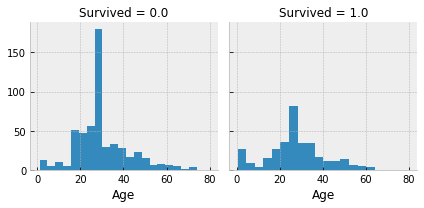

In [86]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Observations.

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.


### Decisions.

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age  in our model training.
- Complete the Age feature for null values.
- We should band age groups.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


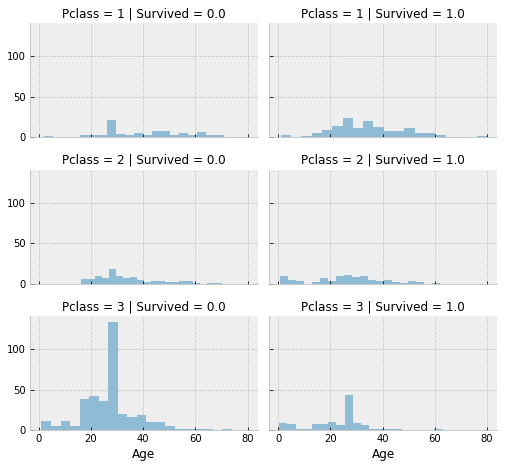

In [87]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features

Now we can correlate categorical features with our solution goal.

#### Observations.

- Female passengers had much better survival rate than males. 
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. 
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. 

#### Decisions.

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


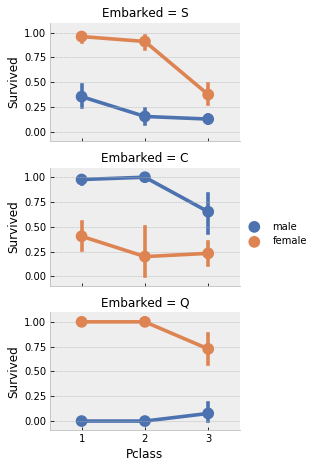

In [88]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


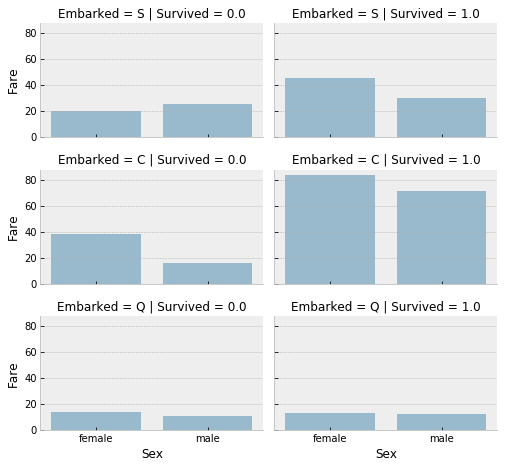

In [89]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

### Correcting by dropping features

In [90]:
# since 'sex' is a binary column, each value can be represented as such
# convert the 'sex' col into a binary indicator column

sex_train = pd.get_dummies(df_train['Sex'], drop_first = True) 
# drop_first = True to take away redundant info
# The first column was a perfect predicotr of the second column

# The same could be done to the 'embark' col
embark_train = pd.get_dummies(df_train['Embarked'], drop_first = True)
# Removing one column could remove the 'perfect predictor' aspect

In [91]:
# Combine the indicator columns with the original dataset and then remove the original columns that were adjusted
df_train_adj = pd.concat([df_train, sex_train, embark_train], axis = 1)
df_train_adj.head()


,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,male,Q,S
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,0,1
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,0,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,0,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,0,1
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,0,1


In [92]:
df_train_adj.drop('Sex', axis = 1, inplace = True)
df_train_adj.drop('Embarked', axis = 1, inplace = True)
df_train_adj.drop('Ticket', axis = 1, inplace = True)


df_train_adj.head()


,Age,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,male,Q,S
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,1,0,1
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,0,0,0
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,1.0,0,0,1
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1.0,0,0,1
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0.0,1,0,1


In [93]:
corr_matrix=df_train_adj.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
Q              0.003650
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.064910
S             -0.149683
Pclass        -0.338481
male          -0.543351
Name: Survived, dtype: float64

In [94]:
sex_test = pd.get_dummies(df_test['Sex'], drop_first = True) 
embark_test = pd.get_dummies(df_test['Embarked'], drop_first = True)

In [95]:
df_test_adj = pd.concat([df_test, sex_test, embark_test], axis = 1)
df_test_adj.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,male,Q,S
0,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,330911,1,1,0
1,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,363272,0,0,1
2,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,240276,1,1,0
3,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,315154,1,0,1
4,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,3101298,0,0,1


In [96]:
df_test_adj.shape

(418, 13)

In [97]:
df_test_adj.drop('Sex', axis = 1, inplace = True)
df_test_adj.drop('Embarked', axis = 1, inplace = True)
df_test_adj.drop('Ticket', axis = 1, inplace = True)
df_test_adj.head()

,Age,Fare,Name,Parch,PassengerId,Pclass,SibSp,male,Q,S
0,34.5,7.8292,"Kelly, Mr. James",0,892,3,0,1,1,0
1,47.0,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,1,0,0,1
2,62.0,9.6875,"Myles, Mr. Thomas Francis",0,894,2,0,1,1,0
3,27.0,8.6625,"Wirz, Mr. Albert",0,895,3,0,1,0,1
4,22.0,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,1,0,0,1


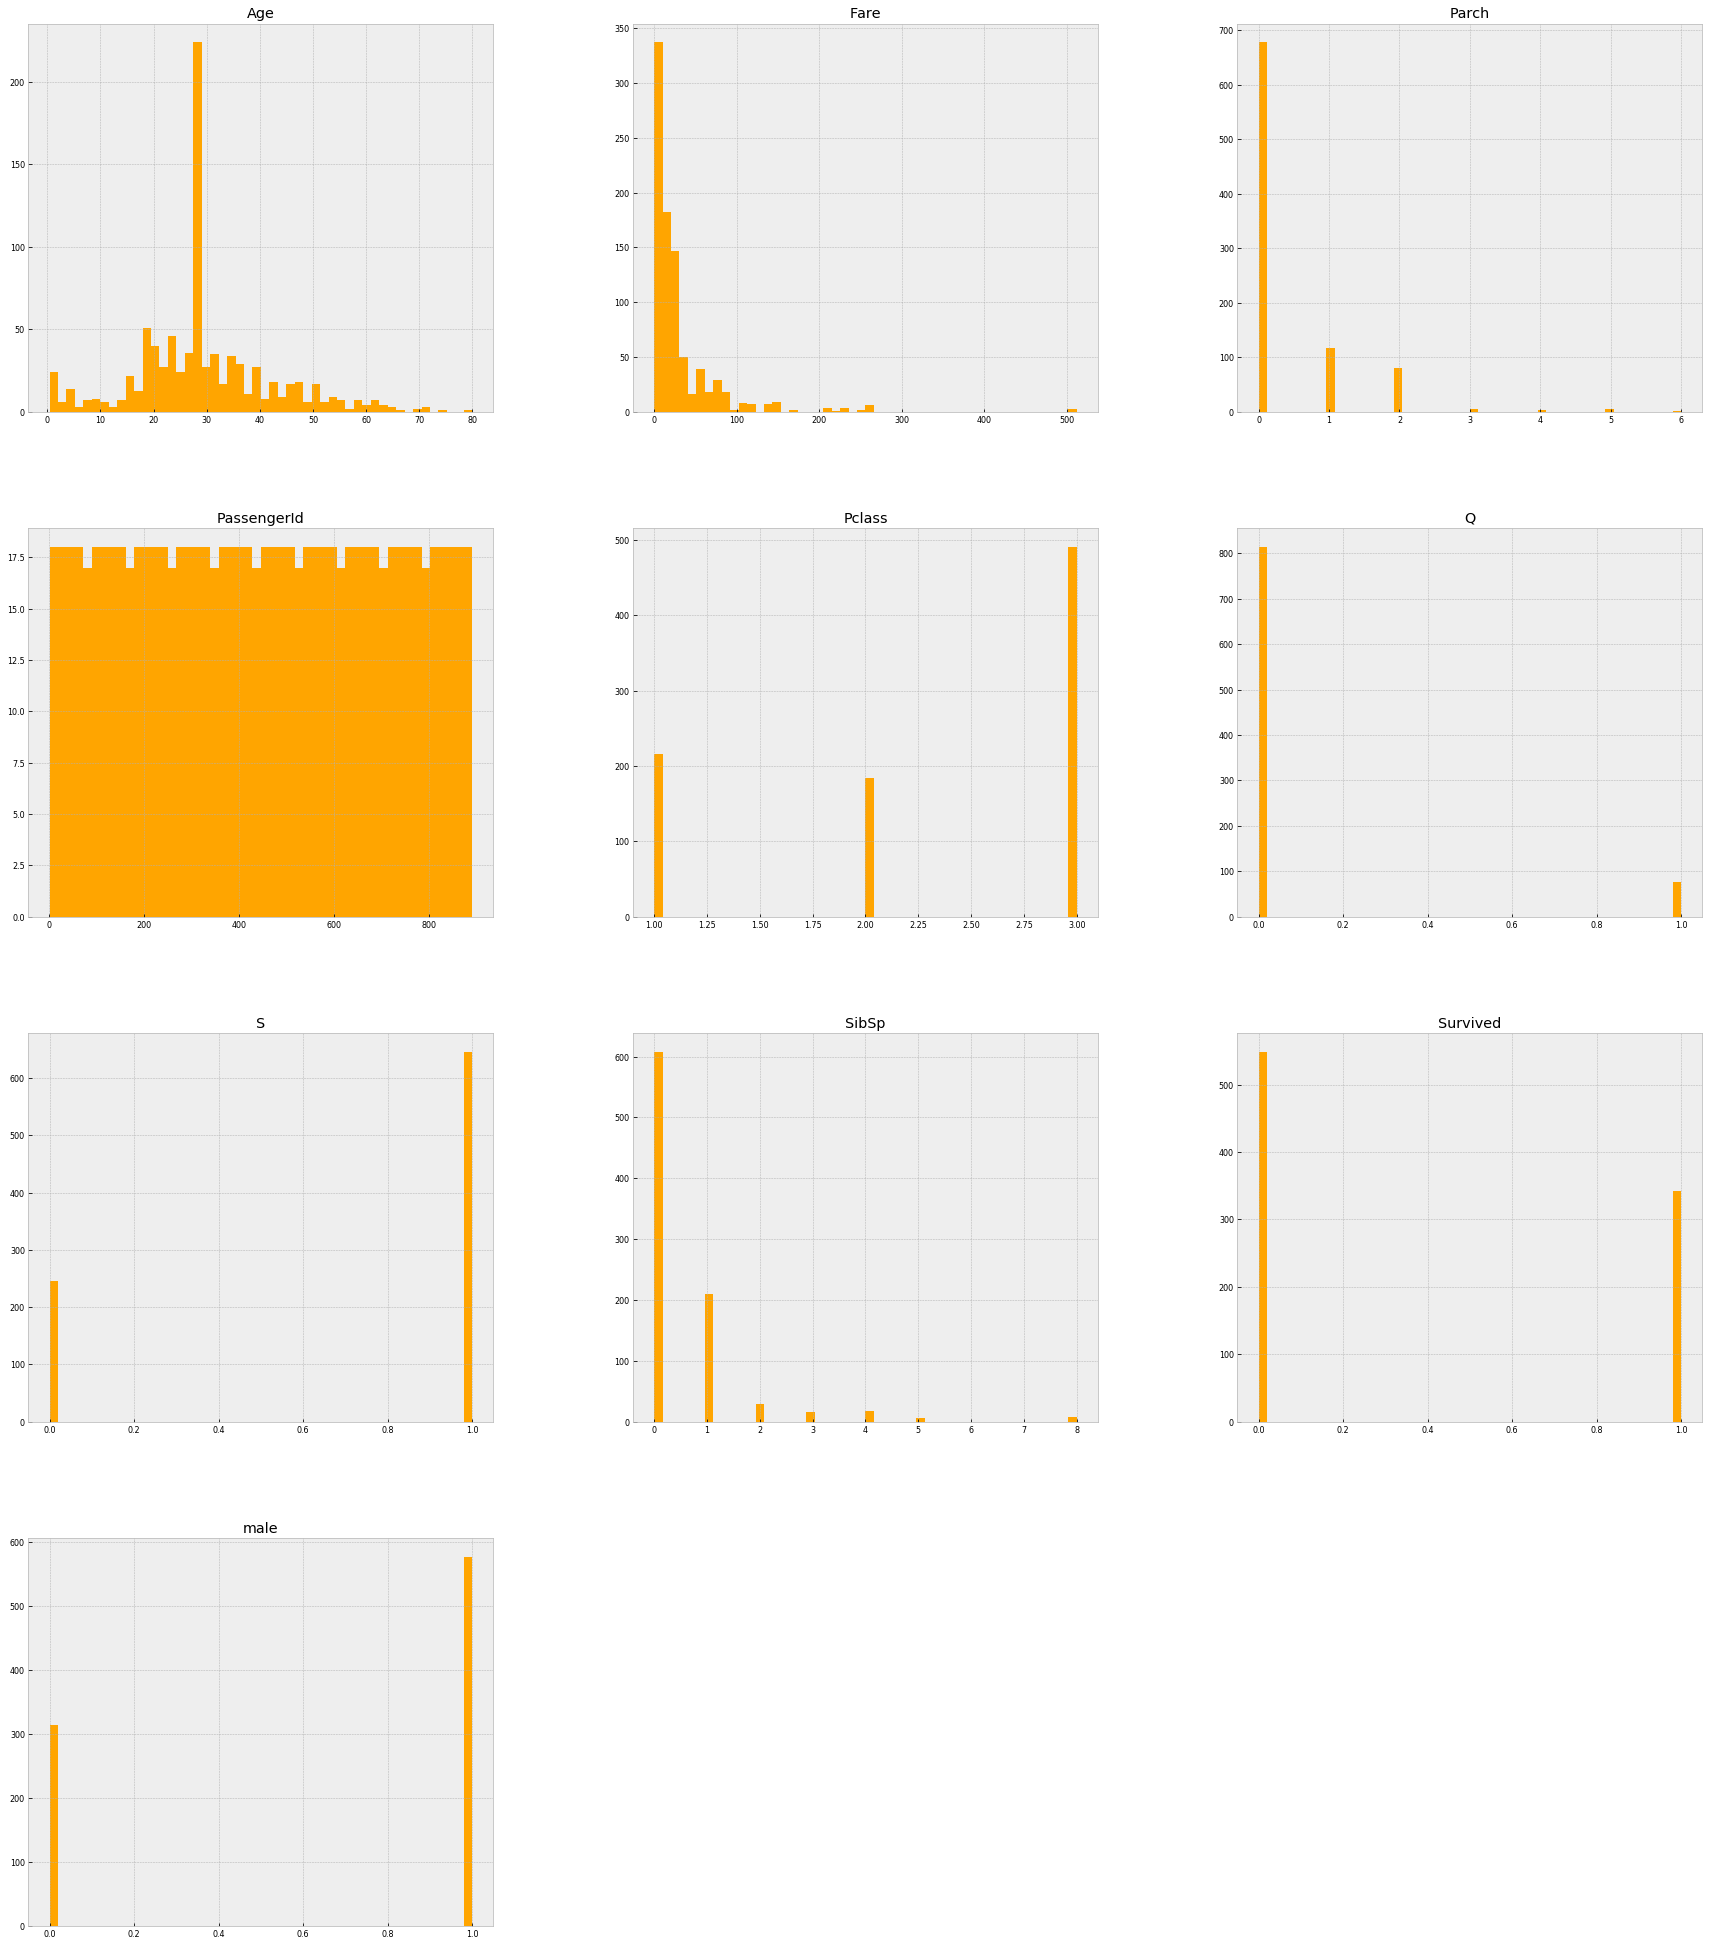

In [98]:
df_train_adj.hist(figsize = (30, 35), bins = 50, xlabelsize = 8, ylabelsize = 8, color='orange');

In the following code we extract Title feature using regular expressions. The RegEx pattern (\w+\.) matches the first word which ends with a dot character within Name feature. The expand=False flag returns a DataFrame.

In [99]:
combine = [df_train_adj, df_test_adj]
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train_adj['Title'], df_train_adj['male'])

male,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as Rare.

In [100]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
df_train_adj[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Can convert the categorical titles to ordinal.

In [101]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

df_train_adj.head()

,Age,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,male,Q,S,Title
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,1,0,1,1
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,0,0,0,3
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,1.0,0,0,1,2
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1.0,0,0,1,3
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0.0,1,0,1,1


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [102]:
df_test_adj.head()

,Age,Fare,Name,Parch,PassengerId,Pclass,SibSp,male,Q,S,Title
0,34.5,7.8292,"Kelly, Mr. James",0,892,3,0,1,1,0,1
1,47.0,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,1,0,0,1,3
2,62.0,9.6875,"Myles, Mr. Thomas Francis",0,894,2,0,1,1,0,1
3,27.0,8.6625,"Wirz, Mr. Albert",0,895,3,0,1,0,1,1
4,22.0,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,1,0,0,1,3


In [105]:
df_train_adj = df_train_adj.drop(['Name','PassengerId'], axis=1)
df_test_adj = df_test_adj.drop(['Name'], axis=1)
combine = [df_train_adj, df_test_adj]
df_train_adj.shape, df_test_adj.shape

((891, 10), (418, 10))

In [106]:
df_train_adj.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,male,Q,S,Title
0,22.0,7.2500,0,3,1,0.0,1,0,1,1
1,38.0,71.2833,0,1,1,1.0,0,0,0,3
2,26.0,7.9250,0,3,0,1.0,0,0,1,2
3,35.0,53.1000,0,1,1,1.0,0,0,1,3
4,35.0,8.0500,0,3,0,0.0,1,0,1,1


Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

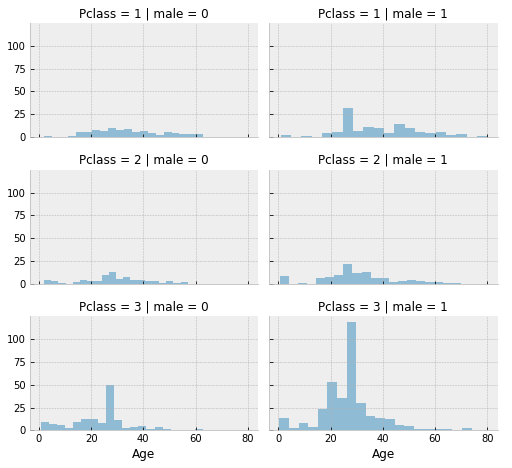

In [107]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(df_train_adj, row='Pclass', col='male', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [108]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [109]:
df_test_adj.head()


,Age,Fare,Parch,PassengerId,Pclass,SibSp,male,Q,S,Title
0,34.5,7.8292,0,892,3,0,1,1,0,1
1,47.0,7.0000,0,893,3,1,0,0,1,3
2,62.0,9.6875,0,894,2,0,1,1,0,1
3,27.0,8.6625,0,895,3,0,1,0,1,1
4,22.0,12.2875,1,896,3,1,0,0,1,3


In [110]:

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['male'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.male == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

df_train_adj.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,male,Q,S,Title
0,22,7.2500,0,3,1,0.0,1,0,1,1
1,38,71.2833,0,1,1,1.0,0,0,0,3
2,26,7.9250,0,3,0,1.0,0,0,1,2
3,35,53.1000,0,1,1,1.0,0,0,1,3
4,35,8.0500,0,3,0,0.0,1,0,1,1


Let us create Age bands and determine correlations with Survived.

In [111]:
df_train_adj['AgeBand'] = pd.cut(df_train_adj['Age'], 5)
df_train_adj[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.344762
2,"(32.0, 48.0]",0.403226
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [112]:
# Mapping Fare
combine = [df_train_adj,df_test_adj]
    
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
df_train_adj.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,male,Q,S,Title,AgeBand
0,22,0,0,3,1,0.0,1,0,1,1,"(16.0, 32.0]"
1,38,3,0,1,1,1.0,0,0,0,3,"(32.0, 48.0]"
2,26,1,0,3,0,1.0,0,0,1,2,"(16.0, 32.0]"
3,35,3,0,1,1,1.0,0,0,1,3,"(32.0, 48.0]"
4,35,1,0,3,0,0.0,1,0,1,1,"(32.0, 48.0]"


In [113]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
df_train_adj.head()

,Age,Fare,Parch,Pclass,SibSp,Survived,male,Q,S,Title,AgeBand
0,1,0,0,3,1,0.0,1,0,1,1,"(16.0, 32.0]"
1,2,3,0,1,1,1.0,0,0,0,3,"(32.0, 48.0]"
2,1,1,0,3,0,1.0,0,0,1,2,"(16.0, 32.0]"
3,2,3,0,1,1,1.0,0,0,1,3,"(32.0, 48.0]"
4,2,1,0,3,0,0.0,1,0,1,1,"(32.0, 48.0]"


Add future Family_size by combining Parch + SibSP

In [114]:
df_train_adj["Family_size"] = df_train_adj["SibSp"] + df_train_adj["Parch"]+1
df_train_adj["IsAlone"] = 1
df_train_adj['IsAlone'].loc[df_train_adj['Family_size'] > 1] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [115]:
df_test_adj["Family_size"] = df_test_adj["SibSp"] + df_test_adj["Parch"]+1
df_test_adj["IsAlone"] = 1
df_test_adj['IsAlone'].loc[df_test_adj['Family_size'] > 1] = 0

In [116]:
df_train_adj = df_train_adj.drop(['SibSp', 'Parch'], axis=1)
df_test_adj = df_test_adj.drop(['SibSp', 'Parch'], axis=1)

In [117]:
df_train_adj = df_train_adj.drop(['Family_size'], axis=1)
df_test_adj = df_test_adj.drop(['Family_size'], axis=1)

In [72]:
df_test_adj.columns

Index(['Age', 'Fare', 'PassengerId', 'Pclass', 'male', 'Q', 'S', 'Title',
       'IsAlone'],
      dtype='object')

In [118]:
df_train_adj = df_train_adj[['Survived','Pclass','male','Age', 'Fare',   'Q', 'S','IsAlone', 'Title']]
df_test_adj = df_test_adj[['PassengerId','Pclass','male','Age', 'Fare',   'Q', 'S','IsAlone', 'Title']]

train = df_train_adj.values
test = df_test_adj.values

## Choosing the Best Model

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid thi

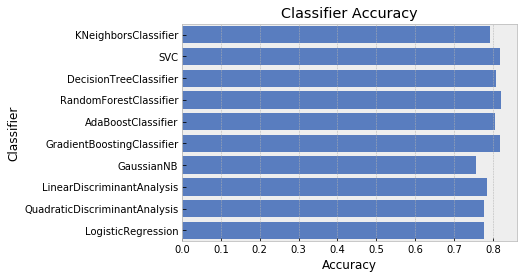

In [135]:

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [120]:
from sklearn.model_selection import train_test_split

predictors = df_train_adj.drop(['Survived'], axis=1)
target = df_train_adj["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

In [121]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

76.65


In [122]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

79.19


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [123]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

80.2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [124]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

77.16


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [125]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

78.17


In [126]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

83.76


In [127]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

82.74


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [128]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

82.23


In [129]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

68.53


In [130]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

81.22


In [131]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Decision Tree,83.76
3,Random Forest,82.74
1,KNN,82.23
9,Gradient Boosting Classifier,81.22
0,Support Vector Machines,80.20
2,Logistic Regression,79.19
5,Perceptron,78.17
6,Linear SVC,77.16
4,Naive Bayes,76.65
8,Stochastic Gradient Descent,68.53


## Creating Submission File

In [139]:
#set ids as PassengerId and predict survival 
ids = df_test_adj['PassengerId']
predictions = gbk.predict(df_test_adj.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)